# PSEUDo vs. MTS metrics: Synthetic Data

In this experiment we will compare the LSH algorithm of PSEUDo to other multivariate time series search strategies using a genome dataset used in PEAX. Because there is no way to compare the quality of 2 different distance metrics (as it is based on personal preference) we can only compare the search strategies in terms of **computing time** and **visually**.

We will compare the following 5 search strategies:
- DTW distance
- Eucledian distance
- PSEUDo LSH strategy
- SAX

In [1]:
%load_ext autoreload
%autoreload 2

We first generate a synthetic dataset

In [14]:
import pandas as pd
import numpy as np
from time import time

datafile = 'data/ethylene_CO.txt'

data = pd.read_csv(datafile, sep='\s+', skiprows=1)
print(data.shape)

#and convert it to numpy array:
npdata = np.array(data.iloc[:, 3:], dtype = "float32")
del data

print(npdata.shape)
print(npdata.dtype)

(4208260, 19)
(4208260, 16)
float32


Extract the time series values from the dataset.

In [15]:
from sklearn import preprocessing

N = 3
T = 200
M = 10000
data = np.array([preprocessing.minmax_scale(npdata[i:i+T, 0:N]) for i in range(0, npdata.shape[0]-T, int(npdata.shape[0]/M))])
del npdata
print(data.shape)

(10020, 200, 3)


We sample a number of subwindows which will be used as query for the search algorithms

In [52]:
import random

# [8246, 4862, 4097, 6805, 9658, 3432, 9945, 6837]
targets = [4862, 9658, 3432, 9945, 6837] #random.sample(list(range(10000)), 10)
print(targets)

[4862, 9658, 3432, 9945, 6837]


The code below plots the first target (for debugging purposes)

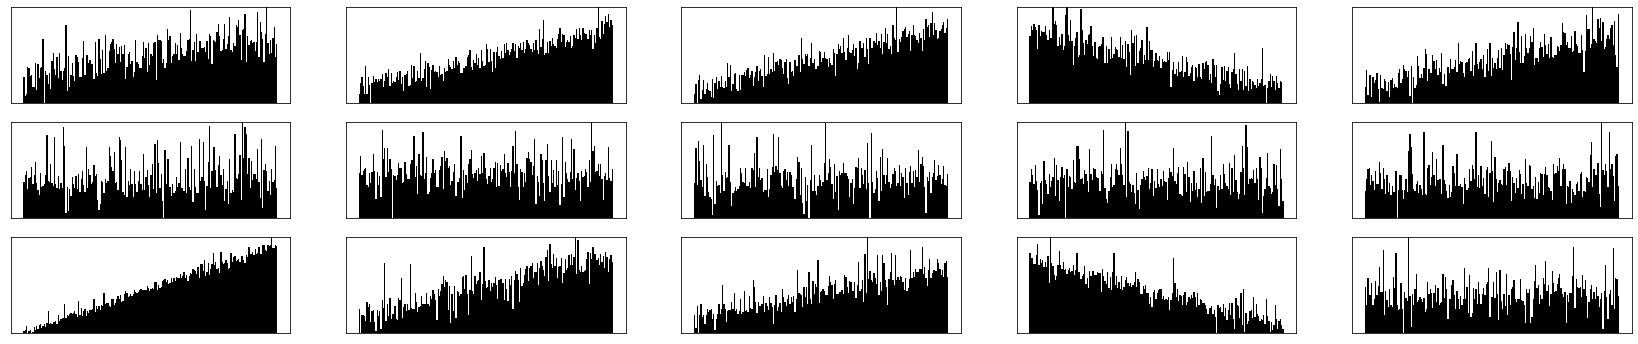

In [53]:
import matplotlib.pyplot as plt 
sz = data.shape[1]
N = 3
T = 100
plt.figure(figsize=(6 * T, 2 * N))

for i, target in enumerate(targets[0:10]):
    for j in range(N):
        plt.subplot(N, T, (T * j) + i + 1)
        plt.bar(np.arange(sz), data[target][:,j], color='black', width=1.0)
        plt.ylim(0, 1)
        plt.xticks([], [])
        plt.yticks([], [])

In [54]:
from time import time

t0 = time()
all_l2_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    l2_distances = [np.linalg.norm(query - window) for window in data]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    l2_candidates = sorted(range(len(l2_distances)), key=lambda k: l2_distances[k])
    all_l2_candidates.append(l2_candidates)
l2_preprocess_time = 0
l2_time = time()-t0

Target #0 done! Took 0.08 seconds (0.0 minutes).
Target #1 done! Took 0.07 seconds (0.0 minutes).
Target #2 done! Took 0.07 seconds (0.0 minutes).
Target #3 done! Took 0.06 seconds (0.0 minutes).
Target #4 done! Took 0.06 seconds (0.0 minutes).


For the LSH algorithm some preprocessing is done to find the right LSH parameters.

In [55]:
import sys

sys.path.insert(0, '../Flaskserver')
import importlib
from pseudo import preprocess
import _lsh

topk_dtw = []

print('Preprocessing:')
t0 = time()
r,a,sd = preprocess(data, data.shape[2])
print('Preprocessing done. Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
pseudo_preprocess_time = time()-t0

Preprocessing:
r = 3
bigger
r = 7.5
smaller
r = 5.25
bigger
r = 6.375
Mean: 7.030375487865732
Stdev: 1.6053518290464985
Ratio mean: 0.896390504635327
Ratio stdev: 0.07240999732268302
Theta: 2.888567768925766
r: 0.3200184373056415
Preprocessing time: 2.4127285480499268
Preprocessing done. Took 2.41 seconds (0.0 minutes).


Now we run the LSH algorithm for all targets and calculate the most similar subwindows

In [56]:
from collections import defaultdict
t0 = time()
all_lsh_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 0)
#     topk_dtw.append(candidates)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for i in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][i]] += i #lsh_distances[l][k][i]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    all_lsh_candidates.append(candidates)
pseudo_time = time() - t0
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 0.20 seconds (0.0 minutes).
doing lsh
Target #1 done! Took 0.24 seconds (0.0 minutes).
doing lsh
Target #2 done! Took 0.38 seconds (0.0 minutes).
doing lsh
Target #3 done! Took 0.21 seconds (0.0 minutes).
doing lsh
Target #4 done! Took 0.16 seconds (0.0 minutes).
Done! Took 1.21 seconds (0.0 minutes).


In [57]:
from collections import defaultdict
t0 = time()
all_lsh_ed_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 1)
#     topk_dtw.append(candidates)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for i in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][i]] += i #lsh_distances[l][k][i]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    all_lsh_ed_candidates.append(candidates)
pseudo_ed_time = time() - t0
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 0.18 seconds (0.0 minutes).
doing lsh
Target #1 done! Took 0.25 seconds (0.0 minutes).
doing lsh
Target #2 done! Took 0.21 seconds (0.0 minutes).
doing lsh
Target #3 done! Took 0.21 seconds (0.0 minutes).
doing lsh
Target #4 done! Took 0.17 seconds (0.0 minutes).
Done! Took 1.06 seconds (0.0 minutes).


We do the same for DTW

In [58]:
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw
from time import time

t0 = time()
all_dtw_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    dtw_distances = [dtw(window, query, global_constraint='sakoe_chiba', sakoe_chiba_radius=int(0.05 * 120)) for window in data]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    dtw_candidates = sorted(range(len(dtw_distances)), key=lambda k: dtw_distances[k])
    all_dtw_candidates.append(dtw_candidates)
    
dtw_preprocess_time = 0
dtw_time = time() - t0
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 3.07 seconds (0.1 minutes).
Target #1 done! Took 3.12 seconds (0.1 minutes).
Target #2 done! Took 3.31 seconds (0.1 minutes).
Target #3 done! Took 3.09 seconds (0.1 minutes).
Target #4 done! Took 2.70 seconds (0.0 minutes).
Done! Took 15.31 seconds (0.3 minutes).


In [59]:
from tslearn.piecewise import SymbolicAggregateApproximation

t0 = time()
sax = SymbolicAggregateApproximation(n_segments=120, alphabet_size_avg=10)
sax_data = sax.fit_transform(data)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
sax_preprocess_time = time() - t0

Done! Took 10.53 seconds (0.2 minutes).


In [60]:
t0 = time()
all_sax_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = sax_data[target]
    sax_distances = [np.linalg.norm(query - window) for window in sax_data]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    sax_candidates = sorted(range(len(sax_distances)), key=lambda k: sax_distances[k])
    all_sax_candidates.append(sax_candidates)
sax_time = time() - t0

Target #0 done! Took 0.09 seconds (0.0 minutes).
Target #1 done! Took 0.08 seconds (0.0 minutes).
Target #2 done! Took 0.10 seconds (0.0 minutes).
Target #3 done! Took 0.10 seconds (0.0 minutes).
Target #4 done! Took 0.09 seconds (0.0 minutes).


In [ ]:
k = 100
total_recall_pseudo = []
total_precision_pseudo = []
total_precision2_pseudo = []
total_pruned_pseudo = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo.append(pruned)
    total_recall_pseudo.append(recall/k)
    total_precision_pseudo.append(precision/k)
    total_precision2_pseudo.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo)) + "%")

In [ ]:
total_recall_pseudo_ed = []
total_precision_pseudo_ed = []
total_precision2_pseudo_ed = []
total_pruned_pseudo_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_ed_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_ed_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_ed_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_ed_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_ed_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo_ed.append(pruned)
    total_recall_pseudo_ed.append(recall/k)
    total_precision_pseudo_ed.append(precision/k)
    total_precision2_pseudo_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo_ed)) + "%")

In [ ]:
total_recall_ed = []
total_precision_ed = []
total_precision2_ed = []
total_pruned_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_l2_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_l2_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_l2_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_l2_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_l2_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_ed.append(pruned)
    total_recall_ed.append(recall/k)
    total_precision_ed.append(precision/k)
    total_precision2_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_ed)) + "%")

In [ ]:
total_recall_sax = []
total_precision_sax = []
total_precision2_sax = []
total_pruned_sax = []
for i in range(len(targets)):
    top_10_percent = int(len(all_sax_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_sax_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_sax_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_sax_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_sax_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_sax.append(pruned)
    total_recall_sax.append(recall/k)
    total_precision_sax.append(precision/k)
    total_precision2_sax.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_sax)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_sax)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_sax)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_sax)) + "%")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Recall', 'Precision-50', 'Precision-10%']
pseudo_values = [
    100 * np.mean(total_recall_pseudo), 
    100 * np.mean(total_precision_pseudo), 
    100 * np.mean(total_precision2_pseudo)
]
pseudo_error = [
    100 * np.std(total_recall_pseudo), 
    100 * np.std(total_precision_pseudo), 
    100 * np.std(total_precision2_pseudo)
]
pseudo_ed_values = [
    100 * np.mean(total_recall_pseudo_ed), 
    100 * np.mean(total_precision_pseudo_ed), 
    100 * np.mean(total_precision2_pseudo_ed)
]
pseudo_ed_error = [
    100 * np.std(total_recall_pseudo_ed), 
    100 * np.std(total_precision_pseudo_ed), 
    100 * np.std(total_precision2_pseudo_ed)
]
ed_values = [
    100 * np.mean(total_recall_ed), 
    100 * np.mean(total_precision_ed), 
    100 * np.mean(total_precision2_ed)
]
ed_error = [
    100 * np.std(total_recall_ed), 
    100 * np.std(total_precision_ed), 
    100 * np.std(total_precision2_ed)
]
sax_values = [
    100 * np.mean(total_recall_sax), 
    100 * np.mean(total_precision_sax), 
    100 * np.mean(total_precision2_sax)
]
sax_error = [
    100 * np.std(total_recall_sax), 
    100 * np.std(total_precision_sax), 
    100 * np.std(total_precision2_sax)
]

colors = ['#4daf4a', '#377eb8', '#ff7f00',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

x = 1.7 * np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x - width * 1.5, pseudo_values, width, yerr=pseudo_error, color=colors[0], capsize=10, label='PSEUDo (DTW)')
rects2 = ax.bar(x - width * 0.5, pseudo_ed_values, width, yerr=pseudo_ed_error, color=colors[1], capsize=10, label='PSEUDo (ED)')
rects3 = ax.bar(x + width * 0.5, sax_values, width, yerr=sax_error,  color=colors[8], capsize=10, label='SAX')
rects4 = ax.bar(x + width * 1.5, ed_values, width, yerr=ed_error, color=colors[6], capsize=10, label='ED')

ax.set_ylabel('% Relative to DTW')
ax.set_title('Recall and precision compared to DTW [Synthetic]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),0)
        ax.annotate('{}'.format(height)+'%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.savefig('images/accuracy_synthetic')
plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['PSEUDo (DTW)', 'PSEUDo (ED)', 'DTW', 'L2', 'SAX']
preprocess_vales = [pseudo_preprocess_time, pseudo_preprocess_time, dtw_preprocess_time, l2_preprocess_time, sax_preprocess_time]
query_values = np.array([pseudo_time, pseudo_ed_time, dtw_time, l2_time, sax_time])

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x - width/2, preprocess_vales, width, color=colors[1], label='Preprocessing')
rects2 = ax.bar(x + width/2, query_values, width, color=colors[0], label='Querying')

ax.set_ylabel('Time (s)')
ax.set_title('Processing times of various search strategies [Synthetic]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('images/visual_similarity_time_complexity')

plt.show()


In [ ]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3

plt.figure(figsize=(1 * columns, nr_of_metrics * 1.5))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

i = 0
for d in range(3):
    ax = plt.subplot(rows, columns, 1 + d)
    ax.set_title('Track ' + str(d+1), fontsize=12, pad=20)
    ax.set_facecolor("#eeeeee")

    plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 7 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUD0 (DTW)', fontsize=10, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')  

        plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 25 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUDo (ED)', fontsize=10, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')        
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 43 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('DTW', fontsize=10, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_l2_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 61 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('ED', fontsize=10, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 79 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('SAX', fontsize=10, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

Check visually

In [ ]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3

plt.figure(figsize=(1.5 * columns, nr_of_metrics * 2))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

i = 1
for d in range(3):
    ax = plt.subplot(rows, columns, 1 + d)
    ax.set_title('Track ' + str(d+1), fontsize=15, pad=20)
    ax.set_facecolor("#eeeeee")

    plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 7 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUD0 (DTW)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')  

        plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 25 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUDo (ED)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')        
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 43 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('DTW', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_l2_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 61 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('ED', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 79 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('SAX', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

In [ ]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3

plt.figure(figsize=(1.5 * columns, nr_of_metrics * 2))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

i = 2
for d in range(3):
    ax = plt.subplot(rows, columns, 1 + d)
    ax.set_title('Track ' + str(d+1), fontsize=15, pad=20)
    ax.set_facecolor("#eeeeee")

    plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 7 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUD0 (DTW)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')  

        plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 25 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUDo (ED)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')        
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 43 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('DTW', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_l2_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 61 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('ED', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 79 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('SAX', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

In [ ]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3

plt.figure(figsize=(1.5 * columns, nr_of_metrics * 2))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

i = 3
for d in range(3):
    ax = plt.subplot(rows, columns, 1 + d)
    ax.set_title('Track ' + str(d+1), fontsize=15, pad=20)
    ax.set_facecolor("#eeeeee")

    plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 7 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUD0 (DTW)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')  

        plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 25 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUDo (ED)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')        
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 43 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('DTW', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_l2_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 61 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('ED', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 79 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('SAX', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

In [ ]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3

plt.figure(figsize=(1.5 * columns, nr_of_metrics * 2))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

i = 4
for d in range(3):
    ax = plt.subplot(rows, columns, 1 + d)
    ax.set_title('Track ' + str(d+1), fontsize=15, pad=20)
    ax.set_facecolor("#eeeeee")

    plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 7 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUD0 (DTW)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_linewidth('5')  

        plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 25 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('PSEUDo (ED)', fontsize=12, labelpad=20)
        if hit not in all_dtw_candidates[i][:50]:
            ax.patch.set_edgecolor('red')  
            ax.patch.set_line5986width('5')        
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 43 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('DTW', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_l2_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 61 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('ED', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
        ax = plt.subplot(rows, columns, 79 + d + (j * 3))
        if j == 2 and d == 0:
            ax.set_ylabel('SAX', fontsize=12, labelpad=20)
        plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

In [ ]:
# import matplotlib.pyplot as plt 

# show = 5

# nr_of_metrics = 5

# rows = (show + 1) * N + 2

# columns = nr_of_metrics

# plt.figure(figsize=(3 * rows, 20 * columns))

# ymax = 1.0

# show_predictions = False

# colors = ['#4daf4a', '#377eb8', '#ff7f00',
#           '#f781bf', '#a65628', '#984ea3',
#           '#999999', '#e41a1c', '#dede00']

# i = 4
# for d in range(3):
#     ax = plt.subplot(rows, columns, 3 + d * (nr_of_metrics * (show + 2)))
#     ax.set_title('Channel ' + str(d+1), fontsize=50, pad=50)
#     ax.set_facecolor("#eeeeee")

#     plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

#     plt.ylim(0, ymax)
#     plt.xticks([], [])
#     plt.yticks([], [])

#     for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
#         ax = plt.subplot(rows, columns, (nr_of_metrics + 1) + j * columns + d * (nr_of_metrics * (show + 2)))
#         if j == show - 1:
#             ax.set_xlabel('PSEUDo (DTW)', fontsize=50, labelpad=50)
#         if hit not in all_dtw_candidates[i][:50]:
#             ax.patch.set_edgecolor('red')  
#             ax.patch.set_linewidth('5')  

#         plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
#         plt.ylim(0, ymax)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.subplots_adjust(top=0.9)

#     for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
#         ax = plt.subplot(rows, columns, (nr_of_metrics + 2) + j * columns + d * (nr_of_metrics * (show + 2)))
#         if j == show - 1:
#             ax.set_xlabel('PSEUDo (ED)', fontsize=50, labelpad=50)
#         if hit not in all_dtw_candidates[i][:50]:
#             ax.patch.set_edgecolor('red')  
#             ax.patch.set_linewidth('5')     
            
#         plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
#         plt.ylim(0, ymax)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.subplots_adjust(top=0.9)

#     for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
#         ax = plt.subplot(rows, columns, (nr_of_metrics + 3) + j * columns + d * (nr_of_metrics * (show + 2)))
#         if j == show - 1:
#             ax.set_xlabel('DTW', fontsize=50, labelpad=50)
#         plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
#         plt.ylim(0, ymax)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.subplots_adjust(top=0.9)

#     for j, hit in enumerate(all_l2_candidates[i][1:show+1]):
#         ax = plt.subplot(rows, columns, (nr_of_metrics + 4) + j * columns + d * (nr_of_metrics * (show + 2)))
#         if j == show - 1:
#             ax.set_xlabel('ED', fontsize=50, labelpad=50)
#         plt.bar(np.arange(sz), data[hit][:,d], color=colors[6], width=1.0)
#         plt.ylim(0, ymax)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.subplots_adjust(top=0.9)

#     for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
#         ax = plt.subplot(rows, columns, (nr_of_metrics + 5) + j * columns + d * (nr_of_metrics * (show + 2)))
#         if j == show - 1:
#             ax.set_xlabel('SAX', fontsize=50, labelpad=50)
#         plt.bar(np.arange(sz), data[hit][:,d], color=colors[8], width=1.0)
#         plt.ylim(0, ymax)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

In [ ]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3 * 5 + 4 

plt.figure(figsize=(1 * columns, nr_of_metrics * 1.6))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

for i in range(5):
    for d in range(3):
        ax = plt.subplot(rows, columns, 1 + d + i * 4)
        ax.set_title('Track ' + str(d+1), fontsize=12, pad=10)
        ax.set_facecolor("#eeeeee")

        plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

        for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 2) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (DTW)', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 8) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (ED)', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 14) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('DTW', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 20) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('ED', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 26) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('SAX', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

In [ ]:
import matplotlib.pyplot as plt 

show = 4

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3 * 5 + 4 

plt.figure(figsize=(1 * columns, nr_of_metrics * 1.6))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

for i in range(5):
    for d in range(3):
        ax = plt.subplot(rows, columns, 1 + d + i * 4)
        ax.set_title('Track ' + str(d+1), fontsize=12, pad=10)
        ax.set_facecolor("#eeeeee")

        plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

        for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 2) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (DTW)', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + show + 1)) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (ED)', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + 2 * (show + 1))) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('DTW', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + 3 * (show + 1))) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('ED', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + 4 * (show + 1))) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('SAX', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))

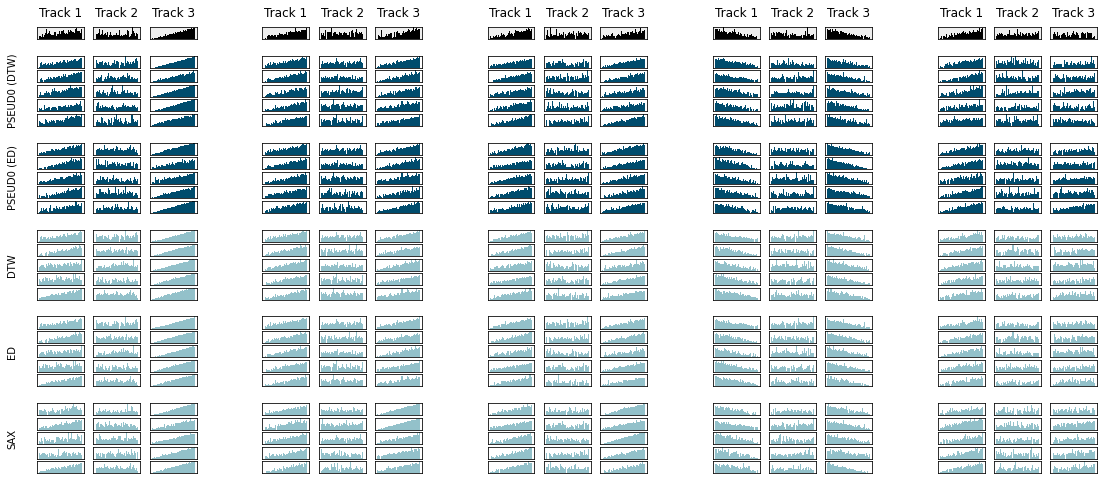

In [63]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3 * 5 + 4 

plt.figure(figsize=(1 * columns, nr_of_metrics * 1.6))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

for i in range(5):
    for d in range(3):
        ax = plt.subplot(rows, columns, 1 + d + i * 4)
        ax.set_title('Track ' + str(d+1), fontsize=12, pad=10)
        ax.set_facecolor("#eeeeee")

        plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

        for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 2) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (DTW)', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + show + 1)) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (ED)', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + 2 * (show + 1))) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('DTW', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + 3 * (show + 1))) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('ED', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * (2 + 4 * (show + 1))) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('SAX', fontsize=10, labelpad=20) 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)
        
            
plt.savefig('images/visual_similarity_2', dpi=300)

<Figure size 432x288 with 0 Axes>

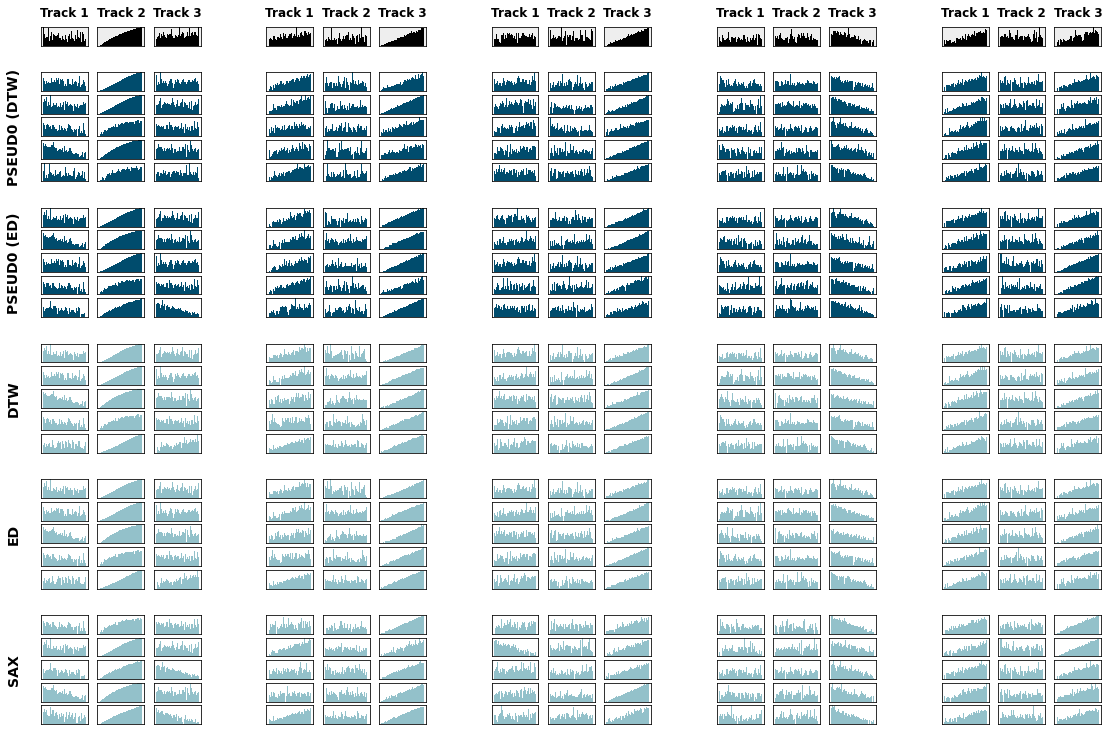

In [37]:
import matplotlib.pyplot as plt 

show = 5

nr_of_metrics = 5

rows = 1 + show * nr_of_metrics + nr_of_metrics

columns = 3 * 5 + 4 

plt.figure(figsize=(1 * columns, nr_of_metrics * 2.5))

ymax = 1.0

show_predictions = False

colors = ['#004c6d', '#004c6d', '#93c1ca', '#93c1ca', '#93c1ca']

for i in range(5):
    for d in range(3):
        ax = plt.subplot(rows, columns, 1 + d + i * 4)
        ax.set_title('Track ' + str(d+1), fontsize=12, pad=10, fontweight='bold')
        ax.set_facecolor("#eeeeee")

        plt.bar(np.arange(sz), data[targets[i]][:,d], color='#000000', width=1.0)

        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

        for j, hit in enumerate(all_lsh_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 2) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (DTW)', fontsize=14, labelpad=20, fontweight='bold') 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[0], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_lsh_ed_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 8) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('PSEUD0 (ED)', fontsize=14, labelpad=20, fontweight='bold') 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[1], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 14) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('DTW', fontsize=14, labelpad=20, fontweight='bold') 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[2], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_dtw_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 20) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('ED', fontsize=14, labelpad=20, fontweight='bold') 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[3], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)

        for j, hit in enumerate(all_sax_candidates[i][1:show+1]):
            ax = plt.subplot(rows, columns, 1 + (columns * 26) + d + (j * columns) + i * 4)
            if j == 2 and d == 0 and i == 0:
                ax.set_ylabel('SAX', fontsize=14, labelpad=20, fontweight='bold') 
            plt.bar(np.arange(sz), data[hit][:,d], color=colors[4], width=1.0)
            plt.ylim(0, ymax)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.subplots_adjust(top=0.9)
            
# plt.savefig('images/visual_similarity_' + str(i+1))